In [9]:
%pip install transformers
%pip install sentence_transformers
%pip install imblearn


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for urllib3<1.27,>=1.21.1 from https://files.pythonhosted.org/packages/b0/53/aa91e163dcfd1e5b82d8a890ecf13314e3e149c05270cc644581f77f17fd/urllib3-1.26.18-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 669.6 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 2.0 MB/s eta 0:00:00 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for urllib3<1.27,>=1.21.1 from https://files.pythonhosted.org/packages/b0/53/aa91e163dcfd1e5b82d8a890ecf13314e3e149c05270cc644581f77f17fd/urllib3-1.26.18-py2.py3-none-any.w

In [1]:
print("WW")

WW


In [2]:
import torch
import pandas as pd
import torchdata
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer, util
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from transformers import pipeline

2023-11-24 01:22:09.644440: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.0.1+cu118
True


In [4]:
def print_simple_data_pipe(date_pipe: torchdata.datapipes.iter.IterDataPipe, f=lambda a: a, n=10) -> None:
  print(type(date_pipe))
  x = 0
  for sample in date_pipe:
    print(f(sample))
    if x == n:
      break
    x +=1


In [5]:
data = pd.read_csv('./train_dataset_train.csv', sep=";")
data.head()

,Исполнитель,Группа тем,Текст инцидента,Тема
0,Лысьвенский городской округ,Благоустройство,"'Добрый день. Сегодня, 20.08.22, моя мать шла ...",★ Ямы во дворах
1,Министерство социального развития ПК,Социальное обслуживание и защита,"'Пермь г, +79194692145. В Перми с ноября 2021 ...",Оказание гос. соц. помощи
2,Министерство социального развития ПК,Социальное обслуживание и защита,'Добрый день ! Скажите пожалуйста если подовал...,Дети и многодетные семьи
3,Город Пермь,Общественный транспорт,'Каждая из них не о чем. Люди на остановках хо...,Содержание остановок
4,Министерство здравоохранения,Здравоохранение/Медицина,'В Березниках у сына привитого откоронавируса ...,Технические проблемы с записью на прием к врачу


In [6]:
theme_group_classes = {j: i for i, j in enumerate(data['Группа тем'].unique())}
theme_group_classes

{'Благоустройство': 0,
 'Социальное обслуживание и защита': 1,
 'Общественный транспорт': 2,
 'Здравоохранение/Медицина': 3,
 'Мусор/Свалки/ТКО': 4,
 'Образование': 5,
 'Дороги': 6,
 'ЖКХ': 7,
 'Коронавирус': 8,
 'Экономика и бизнес': 9,
 'Культура': 10,
 'Связь и телевидение': 11,
 'Газ и топливо': 12,
 'Безопасность': 13,
 'Спецпроекты': 14,
 'Мобилизация': 15,
 'МФЦ "Мои документы"': 16,
 'Физическая культура и спорт': 17,
 'Торговля': 18,
 'Строительство и архитектура': 19,
 'Памятники и объекты культурного наследия': 20,
 'Экология': 21,
 'Государственная собственность': 22,
 'Роспотребнадзор': 23,
 'Погребение и похоронное дело': 24,
 'Электроснабжение': 25}

In [29]:
# name_os, system_os = RandomUnderSampler().fit_resample(data.loc[:, ['Текст инцидента']], data['Группа тем'])
# data_os = pd.DataFrame({'Текст инцидента': name_os['Текст инцидента'], 'Группа тем': system_os})
# print("OS:", data_os.shape)
# print("Prev:", data.shape)
# data_os.head()


# data_os = data.loc[:, ['Текст инцидента', 'Группа тем']]
# data_os

theme_group_counts = data['Группа тем'].value_counts()
b = theme_group_counts[theme_group_counts > theme_group_counts.median()].index.to_list()
data_rem_c = data.loc[data['Группа тем'].apply(lambda a: a in b)]
# data_rem_c.head()
name_os, system_os = RandomUnderSampler().fit_resample(data_rem_c.loc[:, ['Текст инцидента']], data_rem_c['Группа тем'])
data_os = pd.DataFrame({'Текст инцидента': name_os['Текст инцидента'], 'Группа тем': system_os})
print("OS:", data_os.shape)
print("Prev:", data_rem_c.shape)
theme_group_classes = {j: i for i, j in enumerate(data_os['Группа тем'].unique())}
data_os.head()

OS: (1560, 2)
Prev: (22567, 4)


,Текст инцидента,Группа тем
0,'> ['Обращение от жителей города Лысьва из пос...,Безопасность
1,"'Укрыться в безопасное место, а это где? по ул...",Безопасность
2,"'Куйбышева, нариманова,челюскина",Безопасность
3,'На Ленина,Безопасность
4,'В Судозаводе много бродячих собак.,Безопасность


In [167]:
b

['Здравоохранение/Медицина',
 'Социальное обслуживание и защита',
 'Дороги',
 'ЖКХ',
 'Благоустройство',
 'Мусор/Свалки/ТКО',
 'Общественный транспорт',
 'Коронавирус',
 'Образование',
 'Безопасность',
 'Связь и телевидение',
 'Мобилизация',
 'Физическая культура и спорт']

In [157]:
X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(data_os['Текст инцидента'], data_os['Группа тем'], test_size=0.1)
X_train, X_test, y_train, y_test = train_test_split(data_os['Текст инцидента'], data_os['Группа тем'])


In [158]:
pd.DataFrame({'name': X_train_os, 'system': y_train_os}).to_csv('./os_dataset_train.csv', index=False)
pd.DataFrame({'name': X_test_os, 'system': y_test_os}).to_csv('./os_dataset_test.csv', index=False)


In [32]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
sentence_vectorizer = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

In [33]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def processing(pair):
    with torch.no_grad():
        e = tokenizer(pair[0], padding=True, truncation=True, max_length=128, return_tensors='pt')
        k = sentence_vectorizer(**e)
    return (mean_pooling(k, e['attention_mask'])[0], torch.nn.functional.one_hot(torch.tensor([theme_group_classes[pair[1]]]), len(theme_group_classes))[0])

In [34]:
train_pairs = torchdata.datapipes.iter.IterableWrapper(['./os_dataset_train.csv'])
train_pairs = torchdata.datapipes.iter.FileOpener(train_pairs, mode='r', encoding='utf-8', )
train_pairs = train_pairs.parse_csv(skip_lines=1, delimiter=',')
train_pairs = train_pairs.shuffle().map(processing)

In [35]:
train_dataloader = torch.utils.data.DataLoader(train_pairs, batch_size=10)
print_simple_data_pipe(train_dataloader, lambda a: (a[0].shape, a[1].shape), n=1)

<class 'torch.utils.data.dataloader.DataLoader'>
(torch.Size([10, 384]), torch.Size([10, 13]))
(torch.Size([10, 384]), torch.Size([10, 13]))


In [36]:
class ClassificationModel(torch.nn.Module):
    def __init__(self, input_size, output_size) -> None:
        super().__init__()
        self.input_layer = torch.nn.Linear(in_features=input_size, out_features=input_size//2)
        self.input_activation = torch.nn.Tanh()
        self.hidden_layer_1 = torch.nn.Linear(in_features=input_size//2, out_features=input_size//4)
        self.hidden_layer_1_activation = torch.nn.Tanh()
        self.output_layer = torch.nn.Linear(in_features=input_size//4, out_features=output_size)
    
    def forward(self, x):
        y = self.input_layer(x)
        y = self.input_activation(y)
        y = self.hidden_layer_1(y)
        y = self.hidden_layer_1_activation(y)
        y = self.output_layer(y)
        return y
        

In [37]:
model = ClassificationModel(
    input_size=384,
    output_size=13
).to('cuda')

In [38]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


In [39]:
er_list = []

In [48]:
epochs = 20
for epoch in range(epochs):
    print(epoch)
    t = 0
    for x, y in train_dataloader:
        t += 1
        outputs = model(x.to('cuda'))
        # print(1, x.shape)
        loss_value = loss(outputs, y.double().to('cuda'))
        # print(2)
        loss_value.backward(retain_graph=True)
        # if t > 100:
        #     break
        # if len(er_list) > 3:
            # if abs(er_list[-1] - er_list[-2]) < 0.001 and er_list[-1] < 10:
            #     optimizer = torch.optim.Adam(model_GRU.parameters(), lr=100)
            # else:
            #     optimizer = torch.optim.Adam(model_GRU.parameters(), lr=0.0001)
        optimizer.step()
        optimizer.zero_grad()
    er_list.append(loss_value.item())
    print(f'Эпоха {epoch + 1}, Значение функции потерь: {loss_value.item()}')


0
Эпоха 1, Значение функции потерь: 0.022701775619134425
1
Эпоха 2, Значение функции потерь: 0.019798181275837125
2
Эпоха 3, Значение функции потерь: 0.16076483259239469
3
Эпоха 4, Значение функции потерь: 0.01849434757605195
4
Эпоха 5, Значение функции потерь: 0.015323131944751368
5
Эпоха 6, Значение функции потерь: 0.01622485931511619
6
Эпоха 7, Значение функции потерь: 0.012152589776087554
7
Эпоха 8, Значение функции потерь: 0.0131694513016555
8
Эпоха 9, Значение функции потерь: 0.007390543645306025
9
Эпоха 10, Значение функции потерь: 0.37016169095732043
10
Эпоха 11, Значение функции потерь: 0.013543837051838637
11
Эпоха 12, Значение функции потерь: 0.011297355731949212
12
Эпоха 13, Значение функции потерь: 0.005608787812525407
13
Эпоха 14, Значение функции потерь: 0.012665711832232774
14
Эпоха 15, Значение функции потерь: 0.007488457343424671
15
Эпоха 16, Значение функции потерь: 0.0054559365846216686
16
Эпоха 17, Значение функции потерь: 0.0019218039444240276
17
Эпоха 18, Значени

In [41]:
test_pairs = torchdata.datapipes.iter.IterableWrapper(['./os_dataset_test.csv'])
test_pairs = torchdata.datapipes.iter.FileOpener(test_pairs, mode='r', encoding='utf-8', )
test_pairs = test_pairs.parse_csv(skip_lines=1, delimiter=',')
test_pairs = test_pairs.map(processing)

In [42]:
test_dataloader = torch.utils.data.DataLoader(test_pairs, batch_size=1)
print_simple_data_pipe(test_dataloader, lambda a: (a[0].shape, a[1].shape), n=1)

<class 'torch.utils.data.dataloader.DataLoader'>
(torch.Size([1, 384]), torch.Size([1, 13]))
(torch.Size([1, 384]), torch.Size([1, 13]))


In [51]:
t_y = []
r_y = []
for i, j in test_dataloader:
    r = model(i.view(1, -1).to('cuda'))
    # print(r)
    # break
    r_y.append(torch.argmax(r[0]).item())
    t_y.append(torch.argmax(j).item())

In [52]:
print(classification_report(t_y, r_y))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.08      0.06      0.07        31
           2       0.17      0.62      0.26        29
           3       0.00      0.00      0.00        31
           4       0.12      0.12      0.12        26
           5       0.06      0.05      0.05        22
           6       0.46      0.61      0.53        31
           7       0.13      0.13      0.13        39
           8       0.50      0.03      0.06        33
           9       0.26      0.22      0.24        27
          10       0.00      0.00      0.00        22
          11       0.00      0.00      0.00        31
          12       0.10      0.32      0.15        34

    accuracy                           0.17       390
   macro avg       0.15      0.17      0.12       390
weighted avg       0.15      0.17      0.13       390



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
# torch.save(model, './my_model.bin')

<Axes: >

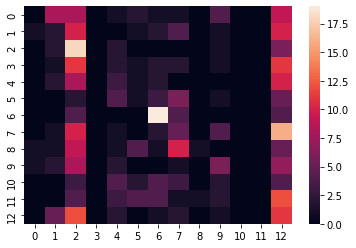

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn
model = torch.load('./my_model.bin')
seaborn.heatmap(confusion_matrix(t_y, r_y))

# Try Model 2

In [139]:
class RecGRUExample(torch.nn.Module):
    def __init__(
        self,
        size_of_sample: int,
        num_of_samples: int,
        output_size_of_input_layer: int,
        output_layer_size: int,
        alpha: float = 5
    ):
        
        super(RecGRUExample, self).__init__()
        self.alpha = alpha
        self.input_size_of_input_layer = size_of_sample
        self.output_size_of_input_layer = output_size_of_input_layer
        self.num_layers_of_input_layer = int(num_of_samples / (alpha * (self.input_size_of_input_layer + self.output_size_of_input_layer)))+1
        self.output_layer_size = output_layer_size
        self.num_of_samples = num_of_samples

        self.input_layer = torch.nn.GRU(
            input_size=self.input_size_of_input_layer,
            hidden_size=self.output_size_of_input_layer,
            num_layers=self.num_layers_of_input_layer,
            # bidirectional = True
        )
        self.output_layer = torch.nn.Conv1d(
            self.num_of_samples,
            self.output_layer_size,
            self.output_size_of_input_layer,
        )

        self.input_activation = torch.nn.Tanh()
        self.h1 = torch.zeros(self.num_layers_of_input_layer, self.num_of_samples, self.output_size_of_input_layer).double().to('cuda')

    def forward(self, x):
        y, h_r = self.input_layer(x, self.h1)
        # print(y.shape)
        y = self.input_activation(y)
        y = self.output_layer(y)
        return y.view(y.shape[0], y.shape[1])


In [159]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    # input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    # print('->', input_mask_expanded.shape, attention_mask.shape, token_embeddings.shape)
    # sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    # sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    k = torch.cat([token_embeddings, torch.zeros(token_embeddings.shape[0], 128 - token_embeddings.shape[1], token_embeddings.shape[2])], 1)
    # print('->', k.shape)
    return k

def processing(pair):
    with torch.no_grad():
        e = tokenizer(pair[0], padding=True, truncation=True, max_length=128, return_tensors='pt')
        k = sentence_vectorizer(**e)
    return (mean_pooling(k, e['attention_mask'])[0], torch.nn.functional.one_hot(torch.tensor([theme_group_classes[pair[1]]]), len(theme_group_classes))[0])
train_pairs = torchdata.datapipes.iter.IterableWrapper(['./os_dataset_train.csv'])
train_pairs = torchdata.datapipes.iter.FileOpener(train_pairs, mode='r', encoding='utf-8', )
train_pairs = train_pairs.parse_csv(skip_lines=1, delimiter=',')
train_pairs = train_pairs.shuffle().map(processing)
train_dataloader = torch.utils.data.DataLoader(train_pairs, batch_size=20)
print_simple_data_pipe(train_dataloader, lambda a: (a[0].shape, a[1].shape), n=1)

<class 'torch.utils.data.dataloader.DataLoader'>
(torch.Size([20, 128, 384]), torch.Size([20, 13]))
(torch.Size([20, 128, 384]), torch.Size([20, 13]))


In [160]:
model_GRU = RecGRUExample(
    size_of_sample=384,
    num_of_samples=128,
    output_size_of_input_layer=50,
    output_layer_size=13,
    alpha=0.1
).double().to('cuda')


In [161]:
model_GRU.num_layers_of_input_layer

3

In [162]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_GRU.parameters(), lr=0.005)
er_list_gru = []

In [163]:
epochs = 20
for epoch in range(epochs):
    t = 1
    for x_b, y_b in train_dataloader:
        outputs = model_GRU(x_b.double().to('cuda'))
        loss_value = loss(outputs, y_b.double().to('cuda'))
        loss_value.backward(retain_graph=True)
        # if len(er_list) > 3:
            # if abs(er_list[-1] - er_list[-2]) < 0.001 and er_list[-1] < 10:
            #     optimizer = torch.optim.Adam(model_GRU.parameters(), lr=100)
            # else:
            #     optimizer = torch.optim.Adam(model_GRU.parameters(), lr=0.0001)
        optimizer.step()
        optimizer.zero_grad()
        if t:
            t = 0
            print('suc')
    er_list_gru.append(loss_value.item())
    print(f'Эпоха {epoch + 1}, Значение функции потерь: {loss_value.item()}')


suc
Эпоха 1, Значение функции потерь: 2.540894632936227
suc
Эпоха 2, Значение функции потерь: 2.70874450415557
suc
Эпоха 3, Значение функции потерь: 2.2583617531305884
suc
Эпоха 4, Значение функции потерь: 2.179774550459036
suc
Эпоха 5, Значение функции потерь: 1.6024841469345894
suc
Эпоха 6, Значение функции потерь: 0.9655391093682145
suc
Эпоха 7, Значение функции потерь: 0.7148856740384374
suc
Эпоха 8, Значение функции потерь: 0.26186403911725503
suc
Эпоха 9, Значение функции потерь: 0.026369152346910445
suc
Эпоха 10, Значение функции потерь: 0.38863185280464463
suc
Эпоха 11, Значение функции потерь: 0.6579126685097848
suc
Эпоха 12, Значение функции потерь: 0.17527231071240182
suc
Эпоха 13, Значение функции потерь: 0.06261208503641771
suc
Эпоха 14, Значение функции потерь: 0.00424386055136043
suc
Эпоха 15, Значение функции потерь: 1.1211695619186919
suc
Эпоха 16, Значение функции потерь: 0.08410756555797129
suc
Эпоха 17, Значение функции потерь: 0.004622175489550602
suc
Эпоха 18, Зна

In [164]:
test_pairs = torchdata.datapipes.iter.IterableWrapper(['./os_dataset_test.csv'])
test_pairs = torchdata.datapipes.iter.FileOpener(test_pairs, mode='r', encoding='utf-8', )
test_pairs = test_pairs.parse_csv(skip_lines=1, delimiter=',')
test_pairs = test_pairs.map(processing)
test_dataloader = torch.utils.data.DataLoader(test_pairs, batch_size=1)
print_simple_data_pipe(test_dataloader, lambda a: (a[0].shape, a[1].shape), n=1)
t_y = []
r_y = []
for i, j in test_dataloader:
    r = model_GRU(i.double().to('cuda'))
    # print(r)
    # break
    r_y.append(torch.argmax(r[0]).item())
    t_y.append(torch.argmax(j).item())

<class 'torch.utils.data.dataloader.DataLoader'>
(torch.Size([1, 128, 384]), torch.Size([1, 13]))
(torch.Size([1, 128, 384]), torch.Size([1, 13]))


In [165]:
print(classification_report(t_y, r_y))

              precision    recall  f1-score   support

           0       0.12      0.25      0.17         8
           1       0.00      0.00      0.00        13
           2       0.13      0.20      0.16        10
           3       0.10      0.11      0.11         9
           4       0.40      0.27      0.32        15
           5       0.60      0.20      0.30        15
           6       0.45      0.31      0.37        16
           7       0.07      0.08      0.08        12
           8       0.00      0.00      0.00        14
           9       0.33      0.60      0.43         5
          10       0.18      0.27      0.22        15
          11       0.38      0.25      0.30        12
          12       0.17      0.17      0.17        12

    accuracy                           0.19       156
   macro avg       0.23      0.21      0.20       156
weighted avg       0.24      0.19      0.20       156



<Axes: >

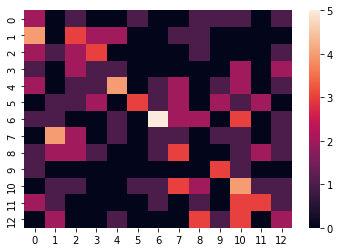

In [166]:
from sklearn.metrics import confusion_matrix
import seaborn
model = torch.load('./my_model.bin')
seaborn.heatmap(confusion_matrix(t_y, r_y))